In [1]:
# PAIRWISE CLASSIFICATION EXAMPLE
# BFgam VS CMgam
# 31/07/2019
require(compiler)
require(MASS)
require(RcppNumerical)
setMKLthreads(20)
#setwd()

Loading required package: compiler
Loading required package: MASS
Loading required package: RcppNumerical


In [2]:
# FOR SIMPLICITY I JUST USE THE SAME SNPs AS IN THE 13-POPULATION CLASSIFICATION
load('Haplotype_16Filtered.RData')
ls()

[1] "haplotype" "label"     "POS"

In [3]:
# JUST SOME FUNCTIONS
fsum<-function(x) {.Primitive('sum')(x)}
gc2<-function() {invisible(gc())}

In [4]:
# CHOOSE THE TWO TARGETED POPULATIONS
pop1<-'BFgam'
pop2<-'CMgam'
haplotype1<-haplotype[label==pop1,]
haplotype2<-haplotype[label==pop2,]
dim(haplotype1)
dim(haplotype2)
rm(haplotype); gc2(); 

[1]    184 117461

[1]    594 117461

In [5]:
# FILTER MAF ON THE COMBINED POPULATION. RETAIN THE ALLELE FREQ (freq) VECTOR
mode(haplotype1)<-'numeric'
mode(haplotype2)<-'numeric'
freq<-apply(rbind(haplotype1, haplotype2), 2, fsum)/(nrow(haplotype1)+nrow(haplotype2))
maf<-freq
maf[maf>0.5]<-1-maf[maf>0.5]

In [6]:
# SELECT LOCI WITH MAF>5%?
s<-(maf>=0.05)
sum(s)
#plot(maf1, maf2)
haplotype1<-haplotype1[,s]
haplotype2<-haplotype2[,s]
freq<-freq[s]
POS<-POS[s]
dim(haplotype1)
dim(haplotype2)
length(POS)
rm(maf); rm(s); gc2(); 
# 107195 LOCI REMAINING

[1] 107195

[1]    184 107195

[1]    594 107195

[1] 107195

In [7]:
# I DON'T THINK I NEED ANOTHER ROUND OF LD PRUNNING. 
# NOW LOOK AT PRIVATE ALLELES OUT OF THESE 107195 LOCI?
freq1<-apply(haplotype1, 2, fsum)/nrow(haplotype1)
freq2<-apply(haplotype2, 2, fsum)/nrow(haplotype2)

sum(freq1==0 & freq2>0)
sum(freq1==1 & freq1<1)
sum(freq2==0 & freq1>0)
sum(freq2==1 & freq1<1)
rm(freq1); rm(freq2); gc2(); 
# SO THE CONCLUSION IS THAT THERE AREN'T TOO MANY PRIVATE ALLELES IN THIS EXAMPLE

[1] 1

[1] 0

[1] 0

[1] 0

In [8]:
# CREATE GENOTYPE DATASETS AND POPULATION LABELS
odd<-seq(1, nrow(haplotype1), 2)
even<-seq(2, nrow(haplotype1), 2)
genotype1<-haplotype1[odd,]+haplotype1[even,]
rm(odd); rm(even);
odd<-seq(1, nrow(haplotype2), 2)
even<-seq(2, nrow(haplotype2), 2)
genotype2<-haplotype2[odd,]+haplotype2[even,]
rm(odd); rm(even);
dim(genotype1)
dim(genotype2)
genotype_both<-rbind(genotype1, genotype2)
label1<-rep(pop1, nrow(genotype1))
label2<-rep(pop2, nrow(genotype2))
label_both<-c(label1, label2)
col1<-rep(1, nrow(genotype1))
col2<-rep(2, nrow(genotype2))
col_both<-c(col1, col2)
rm(haplotype1); rm(haplotype2); gc2();

[1]     92 107195

[1]    297 107195

In [9]:
# SUPERVISED LEARNING
# THE PLAN IS USE LOGISTIC REGRESSION AS THE CLASSIFIER
# BUT THE FIRST STEP IS ALWATS TO SPLIT INTO TRAINING AND TESTING SET. 80:20, STRATIFIED. 
set.seed(12345)
s<-sample(nrow(genotype1), size=round(0.8*nrow(genotype1)))
train_genotype1<-genotype1[s,]
test_genotype1<-genotype1[-s,]
train_label1<-label1[s]
test_label1<-label1[-s]
train_col1<-col1[s]
test_col1<-col1[-s]
rm(s)
s<-sample(nrow(genotype2), size=round(0.8*nrow(genotype2)))
train_genotype2<-genotype2[s,]
test_genotype2<-genotype2[-s,]
train_label2<-label2[s]
test_label2<-label2[-s]
train_col2<-col2[s]
test_col2<-col2[-s]
rm(s)
# COMBINE THE TWO POPULATIONS
train_genotype<-rbind(train_genotype1, train_genotype2)
train_label<-c(train_label1, train_label2)
train_col<-c(train_col1, train_col2)
test_genotype<-rbind(test_genotype1, test_genotype2)
test_label<-c(test_label1, test_label2)
test_col<-c(test_col1, test_col2)
# y IS THE NUMERIC VERSION OF train_label. 0=pop1, 1=pop2
y<-as.numeric(train_label==pop2)

In [10]:
# CHECK DIMINSIONS (OPTIONAL, JUST FOR ERROR CHECKING)
#dim(train_genotype)
#length(train_label)
#length(train_col)
#dim(test_genotype)
#length(test_label)
#length(test_col)

In [11]:
# 1) LOGISTIC REGRESSION ON THE RAW GENOTYPE. WILL IT WORK?
#m<-glm(train_label~train_genotype, family='binomial')

In [12]:
# THE PLAIN VANILLA glm() IS TOO SLOW
# TRY USING fastLR() FROM RcppNumerical PACKAGE
# BUT IT DOESN'T RETURN T STATISTICS OR P-VALUES
system.time(m_lr<-fastLR(y=y, x=train_genotype, maxit=1000))
# THE MAXIMISED LOG-LIKELIHOOD VALUE
m_lr$loglikelihood

   user  system elapsed 
   3.73    0.02    3.75 

[1] -6.545997e-08

In [13]:
# TO SEE THE FITTED VALUES OF THE TRAIN SET
# temp IS THE LINEAR PREDICTOR. IF temp<0 IT IS pop1=BFgam
# THE REASON FOR LOOKING AT THIS IS BECAUSE IF WE GOT 100% "ACCURACY" ON THE TRAIN SET BUT A MUCH LOWER ONE ON THE TEST SET
# THIS COULD MEAN OVER-FITTING
temp<-train_genotype%*%m_lr$coefficients
fitted_train_lr<-ifelse(temp<0, pop1, pop2)
sum(fitted_train_lr==train_label)/length(train_label)

[1] 1

In [14]:
# HOW ABOUT FITTING TO THE TEST SET?
temp<-test_genotype%*%m_lr$coefficients
#data.frame(linear_predictor=temp, test_label=test_label)
# TEST SET PREDICTION AND ACCURACY, ABOUT 81%
predict_lr<-ifelse(temp<0, pop1, pop2)
sum(predict_lr==test_label)/length(test_label)

[1] 0.8181818

In [15]:
# 2) LOGISTIC WITH PCA-REDUCED DATA
# IT MAY NOT BE A NICE THING TO HAVE NUMBER OF PARAMETERS>>>SAMPLES. 
# FIRST APPLY PATTERSON'S NORMALISATION
train_freq<-apply(train_genotype, 2, fsum)/(2*nrow(train_genotype))
train_freq2<-matrix(train_freq, ncol=ncol(train_genotype), nrow=nrow(train_genotype), byrow=T)
normal_train_genotype<-(train_genotype-2*train_freq2)/sqrt(train_freq2*(1-train_freq2))
rm(train_freq2); gc2(); 

In [16]:
# PCA VIA prcomp(). USE FIRST n COMPONENTS
system.time(e<-prcomp(normal_train_genotype))
n<-100
train_feature<-normal_train_genotype%*%e$rotation[,1:n]
dim(train_feature)

   user  system elapsed 
  24.47    0.97    3.01 

[1] 312 100

In [17]:
# RUN A LOGISTIC REGRESSION. NO INTERCEPT
# OFTEN WE NEED TO PUT THINGS IN A data.frame
train_df<-data.frame(train_label=train_label, train_feature=train_feature)
m_lrpca<-glm(train_label~.-1, data=train_df, family='binomial')

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [18]:
# SADLY NONE OF THE PCs IS STATISTICALLY SIGNIFICANT
# PATTERSON TRANSFORM THE TEST SET, AND CREATE TEST FEATURES
test_freq2<-matrix(train_freq, nc=ncol(test_genotype), nr=nrow(test_genotype), byrow=T)
normal_test_genotype<-(test_genotype-2*test_freq2)/sqrt(test_freq2*(1-test_freq2))
test_feature<-normal_test_genotype%*%e$rotation[,1:n]
dim(test_feature)
rm(train_freq); rm(test_freq2); invisible(gc());

[1]  77 100

In [19]:
# TO SEE FITTED VALUES ON THE TRAIN SET
temp<-predict(m_lrpca, train_df, type='response')
fitted_train_lrpca<-ifelse(temp<0.5, pop1, pop2)
sum(fitted_train_lrpca==train_label)/length(train_label)

[1] 1

In [20]:
# FIT TO THE TEST SET. SOMETIMES YOU JUST NEED TO PUT THINGS INTO A DATA FRAME... AND WITH THE "CORRECT" COLUMN NAMES...
test_df<-data.frame(test_feature=test_feature)
names(test_df)<-names(train_df)[-1]
predict_lrpca<-predict(m_lrpca, test_df, type='response')
predict_lrpca<-ifelse(predict_lrpca<0.5, pop1, pop2)
# ACCURACY, ~89%
sum(predict_lrpca==test_label)/length(test_label)

[1] 0.8961039

In [21]:
# NOW TRY LDA ON THE PCA-REDUCED DATA. WE EXPECT LDA IS WORSE THAN LOGISTIC WITH ONLY TWO CATEGORIES
m_ldapca<-lda(train_feature, grouping=train_label, prior=c(0.5,0.5))
predict_ldapca<-predict(m_ldapca, test_feature, type='class')$class
predict_ldapca<-as.character(predict_ldapca)
# ACCURACY, ~78%
sum(predict_ldapca==test_label)/length(test_label)

[1] 0.7792208

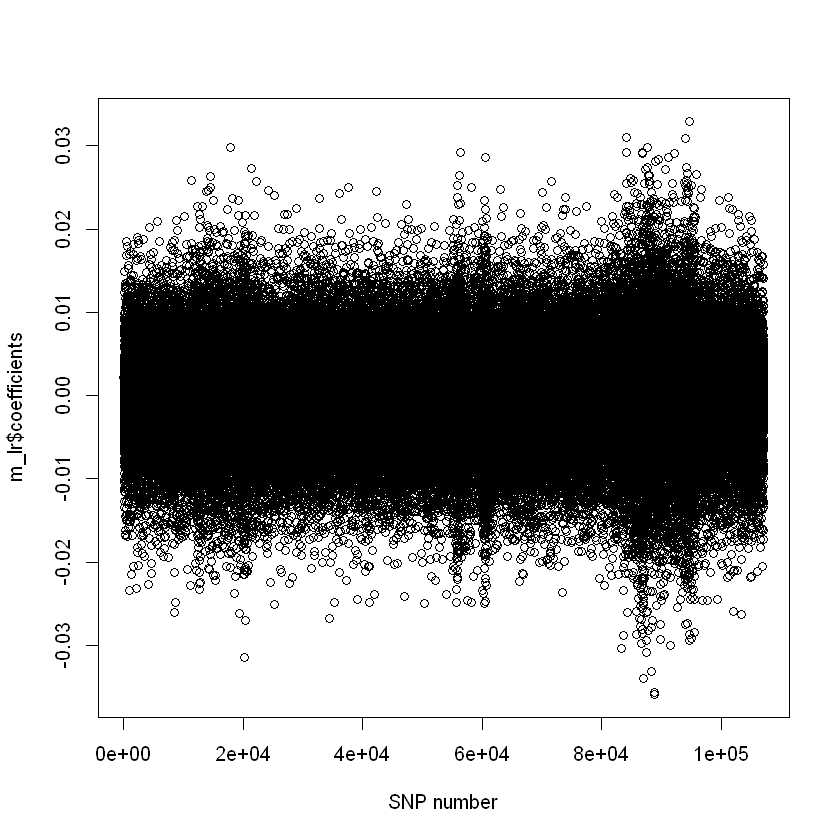

,POS,coef
88870,30043067,-0.03593741
88847,30041338,-0.03566259
86947,28241498,-0.03400762
88383,29309533,-0.03319328
94754,31736265,0.03296181
20123,6880356,-0.03142650
84152,27264636,0.03101824
94092,31628425,0.03091367
87483,28630086,-0.03090610
83291,27121724,-0.03039591


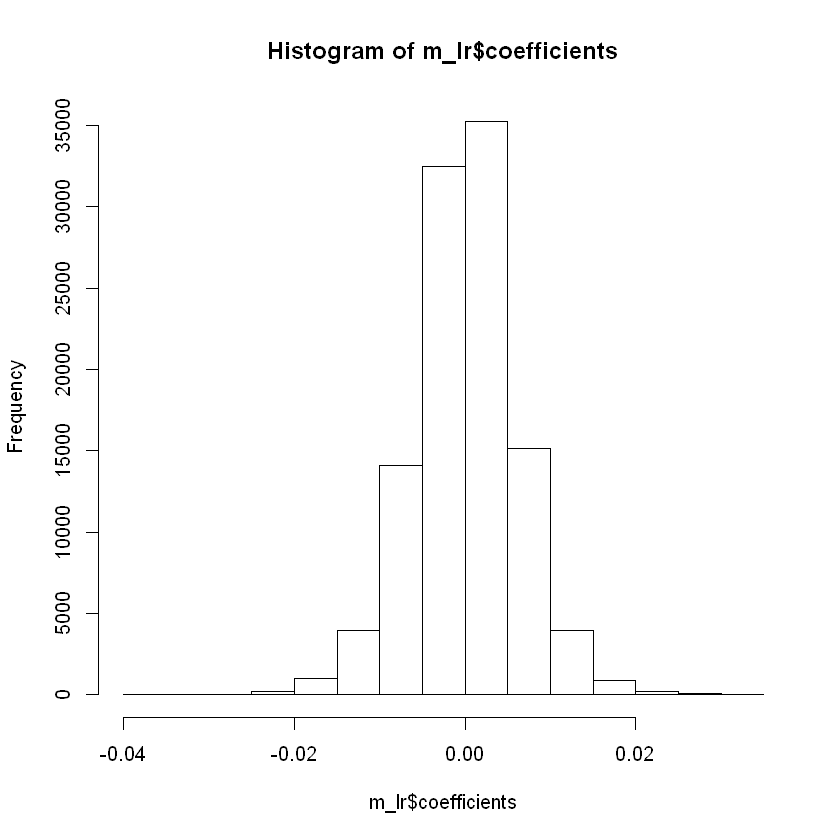

In [22]:
# SNPs CONTRIBUTION FOR THE LOGISTIC REGRESSION?
plot(m_lr$coefficients, xlab='SNP number')
hist(m_lr$coefficients)
contribution_lr<-data.frame(POS=POS, coef=m_lr$coefficients)
# DISPLAY SNPs WITH HIGHEST CONTRIBUTION
contribution_lr[order(abs(contribution_lr$coef), decreasing=T)[1:10],]

In [23]:
# FOR THE PCA-REDUCED DATA, THE REGRESSION COEFFICIENTS ARE THE CONTRIBUTIONS OF PCs
# AND PCs ARE LINEAR COMBINATIONS OF PATTERSON-TRANSFORMED SNPs
contribution_lrpca<-data.frame(POS=POS, coef=as.numeric(e$rotation[,1:n]%*%m_lrpca$coef))
# DISPLAY SNPs WITH HIGHEST CONTRIBUTION
contribution_lrpca[order(abs(contribution_lrpca$coef), decreasing=T)[1:10],]

,POS,coef
94305,31666840,0.05204190
85840,27610866,-0.04900579
94752,31736194,-0.04866684
90380,30399975,-0.04777551
86488,27768561,-0.04747869
94339,31670179,-0.04648656
94324,31668821,0.04596801
87298,28393819,0.04553632
88179,29194308,-0.04478429
88498,29371578,-0.04391138


[1] 0.8168735

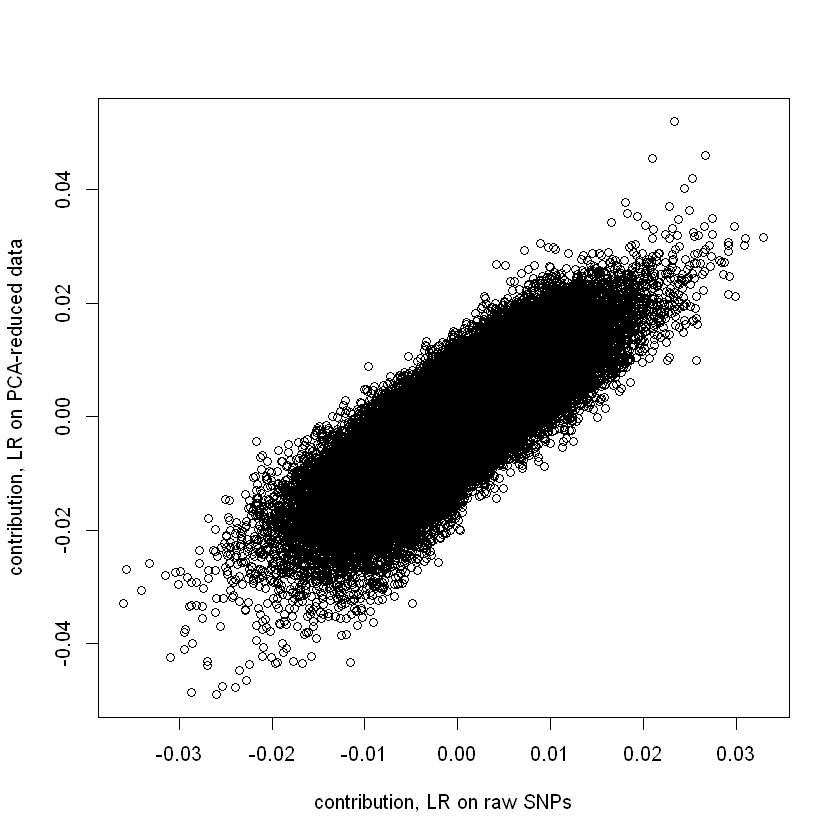

In [26]:
# ANY CORRELATION BETWEEN THE TWO? YES!
plot(contribution_lr$coef, contribution_lrpca$coef, 
    xlab='contribution, LR on raw SNPs', ylab='contribution, LR on PCA-reduced data')
cor(contribution_lr$coef, contribution_lrpca$coef)

In [25]:
# TRY WRITING MY OWN LOGISTIC LOG-LIKELIHOOD FUNCTION INVERSE
# RETURNING 1/LOG_LIKE. THEN MINIMISE IT. 
# parm IS A VECTOR OF PARAMETERS WITH LENGTH EQUALS LOCI NUMBER
/*
log.like.inv<-function(parms)
{
    temp<-train_genotype%*%parms
    temp1<-exp(temp)
    p<-temp1/(1+temp1)
    l<-y*log(p)+(1-y)*log(1-p)
    # REMOVE TOO SMALL PROB
    l2<-l[!is.na(l)]
    return(1/fsum(l2))
}
log.like.inv<-cmpfun(log.like.inv)

# TRY 
log.like.inv(rep(0, length(POS)))
system.time(log.like.inv(rep(0, length(POS))))
*/
# ELAPSE TIME 0.06, TOTAL CPU TIME 1.25s ACROSS 20 CORES. PERFECT SCALING...?
# THE EVALUATION OF THE LOG-LIKE INVOLVES A MATRIX MULTIPLICATION. 
# A GOOD LINPACK DOES THE JOB

ERROR: Error in parse(text = x, srcfile = src): <text>:4:1: unexpected '/'
3: # parm IS A VECTOR OF PARAMETERS WITH LENGTH EQUALS LOCI NUMBER
4: /
   ^
